In [16]:
import pandas as pd
pd.options.mode.chained_assignment = None 

# Feature Engineering

In [17]:
ball_by_ball_df = pd.read_csv('./data/IPL_Ball_by_Ball_2008_2022.csv')
matches_df = pd.read_csv('./data/IPL_Matches_2008_2022.csv')

In [18]:
# Filter for the first innings
first_innings_df = ball_by_ball_df[ball_by_ball_df['innings'] == 1]

# Now we need to engineer the features for each ball in the first innings
# We will perform a cumulative sum for the runs, count the wickets, fours, and sixes, and calculate balls since last wicket
# We'll also calculate the number of legitimate balls bowled

first_innings_df['current_score'] = first_innings_df.groupby('ID')['total_run'].cumsum()
first_innings_df['current_wickets_fallen'] = first_innings_df.groupby('ID')['isWicketDelivery'].cumsum()
first_innings_df['cumulative_fours'] = first_innings_df.groupby('ID').apply(
    lambda x: (x['batsman_run'] == 4).cumsum()
).reset_index(level=0, drop=True)

first_innings_df['cumulative_sixes'] = first_innings_df.groupby('ID').apply(
    lambda x: (x['batsman_run'] == 6).cumsum()
).reset_index(level=0, drop=True)
first_innings_df['legitimate_ball'] = ((first_innings_df['extras_run'] == 0) | (first_innings_df['extra_type'].isna())).astype(int)
first_innings_df['balls_bowled'] = first_innings_df.groupby('ID')['legitimate_ball'].cumsum()
first_innings_df['wicket_delivery'] = first_innings_df['isWicketDelivery'] == 1
first_innings_df['last_wicket_ball'] = first_innings_df.groupby('ID')['wicket_delivery'].cumsum()
first_innings_df['balls_since_last_wicket'] = first_innings_df.groupby(['ID', 'last_wicket_ball']).cumcount()
first_innings_df['runs_since_last_wicket'] = first_innings_df.groupby(['ID', 'last_wicket_ball'])['total_run'].cumsum()

first_innings_with_venue = first_innings_df.merge(matches_df[['ID', 'Venue']], on='ID', how='left')
final_scores = first_innings_with_venue.groupby('ID')['current_score'].max().reset_index()
final_scores.rename(columns={'current_score': 'final_score'}, inplace=True)
final_innings_df = first_innings_with_venue.merge(final_scores, on='ID', how='left')


# Selecting the columns for the final structured dataframe
structured_df = final_innings_df[[
    'ID', 'current_score', 'current_wickets_fallen', 'cumulative_fours', 'cumulative_sixes', 'balls_bowled',
    'balls_since_last_wicket', 'runs_since_last_wicket', 'Venue', 'final_score'
]]
structured_df = structured_df.drop_duplicates().reset_index(drop=True)
structured_df.head()


,ID,current_score,current_wickets_fallen,cumulative_fours,cumulative_sixes,balls_bowled,balls_since_last_wicket,runs_since_last_wicket,Venue,final_score
0,1312200,0,0,0,0,1,0,0,"Narendra Modi Stadium, Ahmedabad",130
1,1312200,1,0,0,0,1,1,1,"Narendra Modi Stadium, Ahmedabad",130
2,1312200,2,0,0,0,2,2,2,"Narendra Modi Stadium, Ahmedabad",130
3,1312200,2,0,0,0,3,3,2,"Narendra Modi Stadium, Ahmedabad",130
4,1312200,2,0,0,0,4,4,2,"Narendra Modi Stadium, Ahmedabad",130


In [19]:
first_innings_scores = ball_by_ball_df[ball_by_ball_df['innings'] == 1].groupby('ID')['total_run'].sum().reset_index()
first_innings_scores.rename(columns={'total_run': 'final_score_first_innings'}, inplace=True)

match_scores = matches_df.merge(first_innings_scores, on='ID', how='left')

first_innings_totals = ball_by_ball_df[ball_by_ball_df['innings'] == 1].groupby('ID').agg(
    total_runs=('total_run', 'sum'),
    total_wickets=('isWicketDelivery', 'sum'),
    total_balls=('ballnumber', 'count') 
).reset_index()

first_innings_totals = first_innings_totals.merge(
    matches_df[['ID', 'Team1', 'Team2', 'TossWinner', 'TossDecision', 'Date']], 
    on='ID', how='left'
)

first_innings_totals['BattingTeam'] = first_innings_totals.apply(
    lambda x: x['Team1'] if x['TossDecision'] == 'bat' and x['TossWinner'] == x['Team1'] or \
              x['TossDecision'] == 'field' and x['TossWinner'] == x['Team2'] else x['Team2'], axis=1
)

first_innings_totals['runs_per_ball'] = first_innings_totals['total_runs'] / first_innings_totals['total_balls']
first_innings_totals['runs_per_wicket'] = first_innings_totals['total_runs'] / first_innings_totals['total_wickets']

# We will now calculate the average of these values for the last three games for each team
first_innings_totals.sort_values(by=['BattingTeam', 'Date'], ascending=True, inplace=True)
first_innings_totals['avg_runs_per_ball_last_3'] = first_innings_totals.groupby('BattingTeam')['runs_per_ball'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
first_innings_totals['avg_runs_per_wicket_last_3'] = first_innings_totals.groupby('BattingTeam')['runs_per_wicket'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Now, we'll select the relevant columns to add to the structured_df
form_features = first_innings_totals[['ID', 'avg_runs_per_ball_last_3', 'avg_runs_per_wicket_last_3']]
structured_df_with_form = structured_df.merge(form_features, on='ID', how='left')

structured_df_with_form.head()

,ID,current_score,current_wickets_fallen,cumulative_fours,cumulative_sixes,balls_bowled,balls_since_last_wicket,runs_since_last_wicket,Venue,final_score,avg_runs_per_ball_last_3,avg_runs_per_wicket_last_3
0,1312200,0,0,0,0,1,0,0,"Narendra Modi Stadium, Ahmedabad",130,1.336934,25.148148
1,1312200,1,0,0,0,1,1,1,"Narendra Modi Stadium, Ahmedabad",130,1.336934,25.148148
2,1312200,2,0,0,0,2,2,2,"Narendra Modi Stadium, Ahmedabad",130,1.336934,25.148148
3,1312200,2,0,0,0,3,3,2,"Narendra Modi Stadium, Ahmedabad",130,1.336934,25.148148
4,1312200,2,0,0,0,4,4,2,"Narendra Modi Stadium, Ahmedabad",130,1.336934,25.148148


# EDA

In [20]:
summary_statistics = structured_df_with_form.describe()

In [21]:
summary_statistics

,ID,current_score,current_wickets_fallen,cumulative_fours,cumulative_sixes,balls_bowled,balls_since_last_wicket,runs_since_last_wicket,final_score,avg_runs_per_ball_last_3,avg_runs_per_wicket_last_3
count,1.168830e+05,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000,116883.000000
mean,8.316926e+05,76.195324,2.406903,7.323589,2.293790,59.048724,16.558139,21.741862,163.138788,1.320086,32.690091
std,3.378237e+05,49.555224,2.020479,4.688191,2.558938,34.081036,16.236037,24.582826,29.796130,0.146597,13.418719
min,3.359820e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,0.897025,11.000000
25%,5.012610e+05,35.000000,1.000000,4.000000,0.000000,29.000000,4.000000,4.000000,144.000000,1.224807,24.077778
50%,8.297390e+05,72.000000,2.000000,7.000000,2.000000,59.000000,12.000000,13.000000,164.000000,1.314034,30.000000
75%,1.178394e+06,113.000000,4.000000,10.000000,3.000000,89.000000,24.000000,31.000000,183.000000,1.420128,37.511111
max,1.312200e+06,263.000000,10.000000,30.000000,21.000000,121.000000,121.000000,229.000000,263.000000,1.935484,118.444444


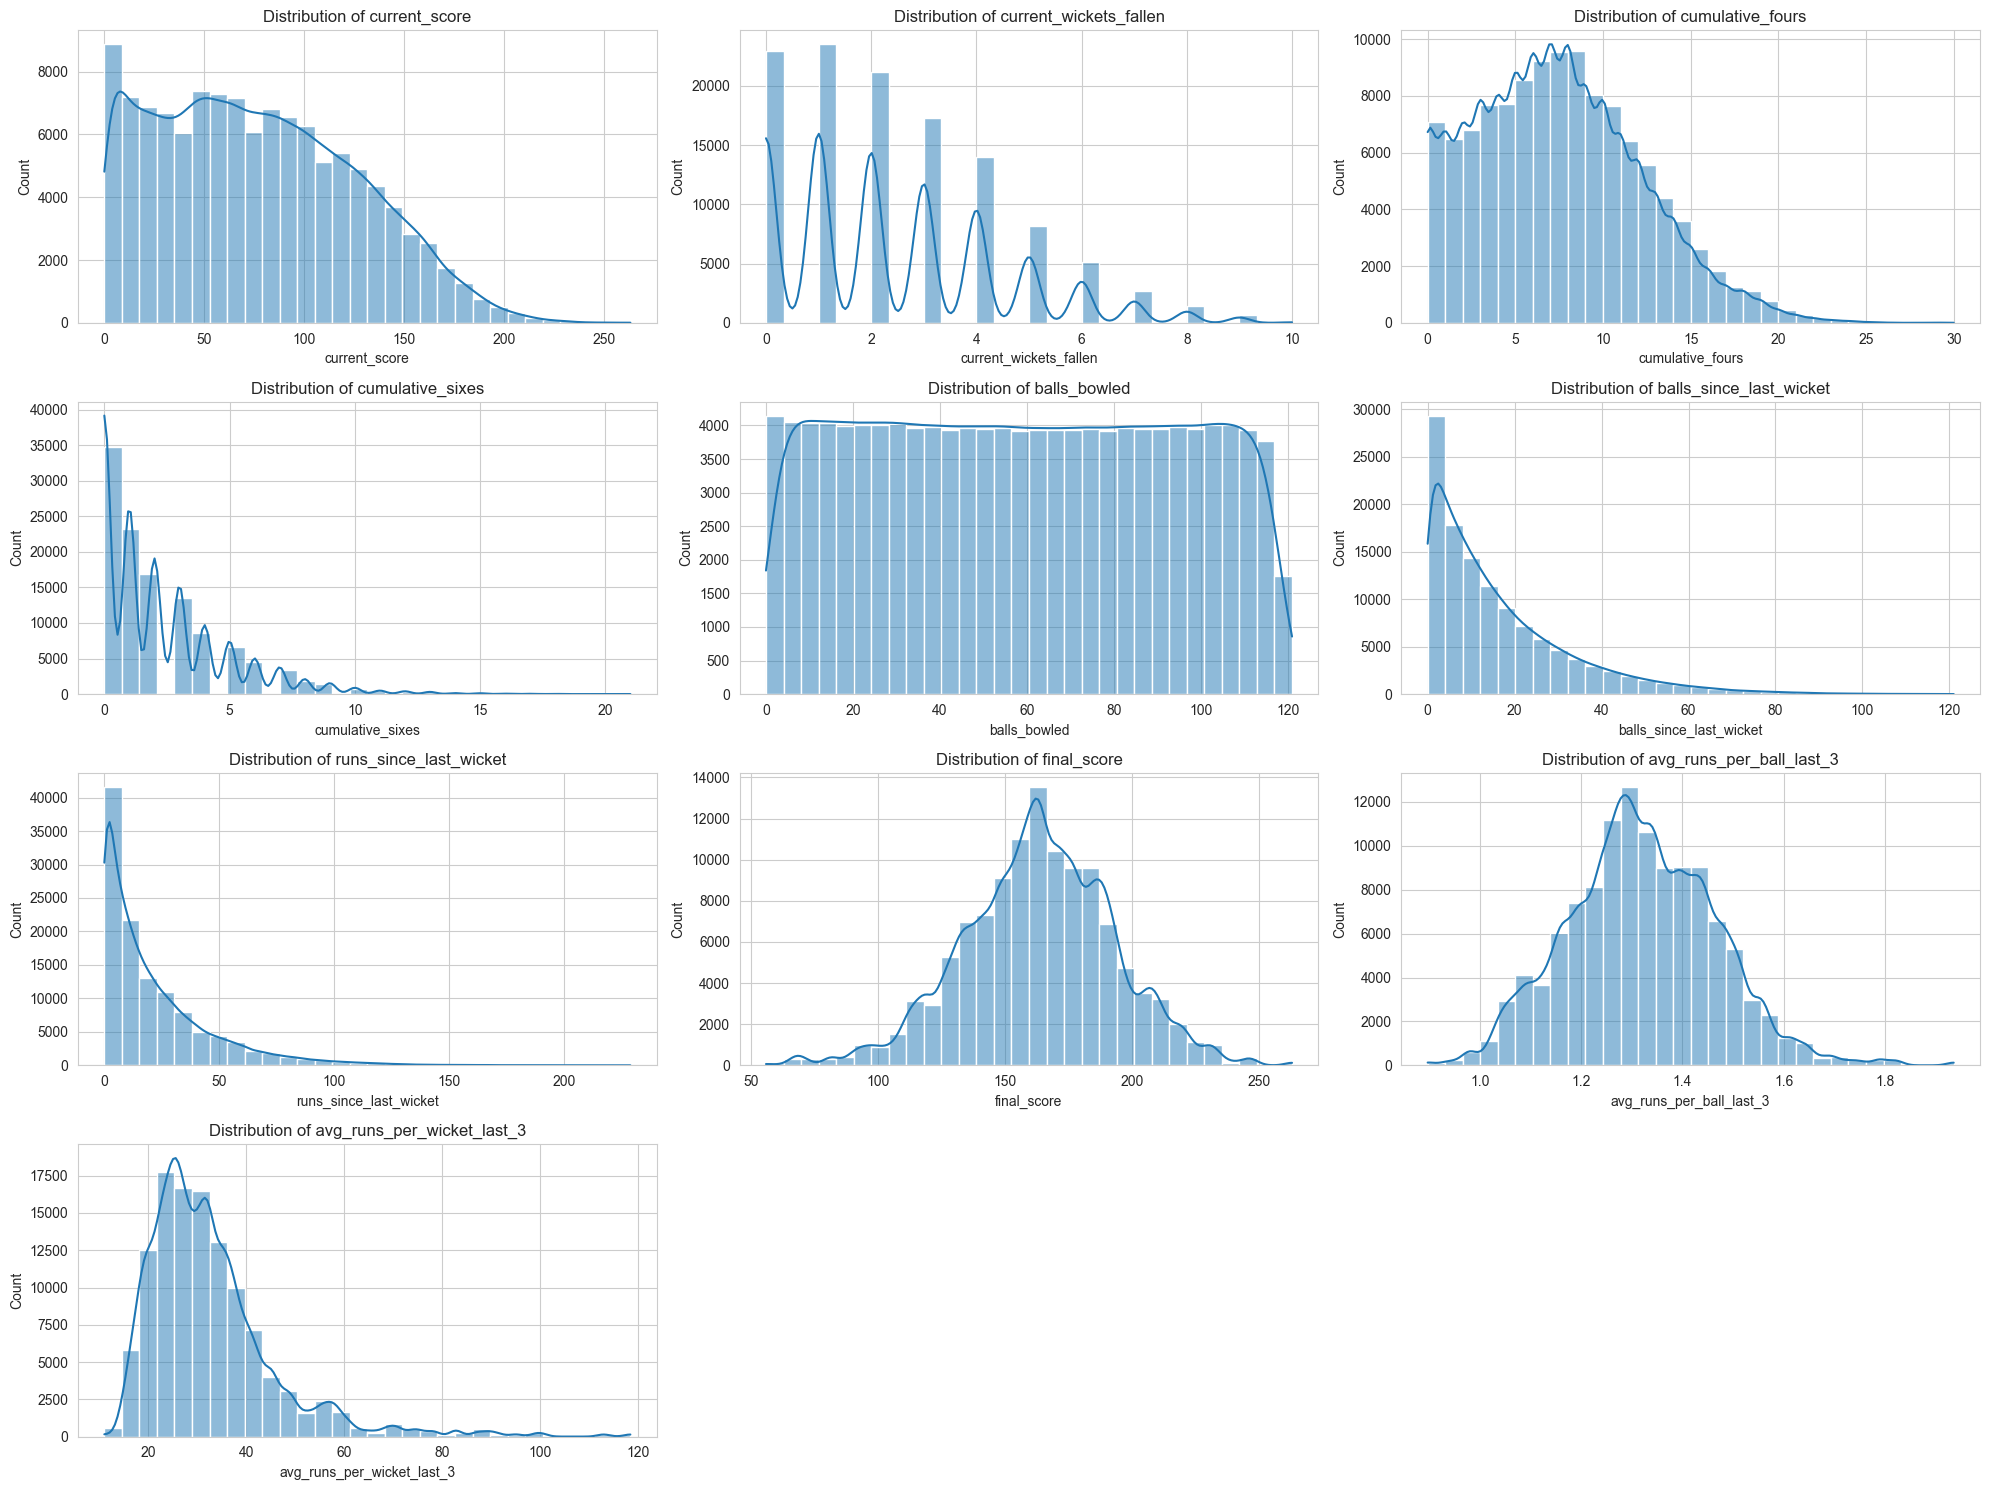

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of numerical features to plot
numerical_features = [
    'current_score', 'current_wickets_fallen', 'cumulative_fours', 'cumulative_sixes', 'balls_bowled',
    'balls_since_last_wicket', 'runs_since_last_wicket', 'final_score',
    'avg_runs_per_ball_last_3', 'avg_runs_per_wicket_last_3'
]

# Plot histograms for numerical features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(structured_df_with_form[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()


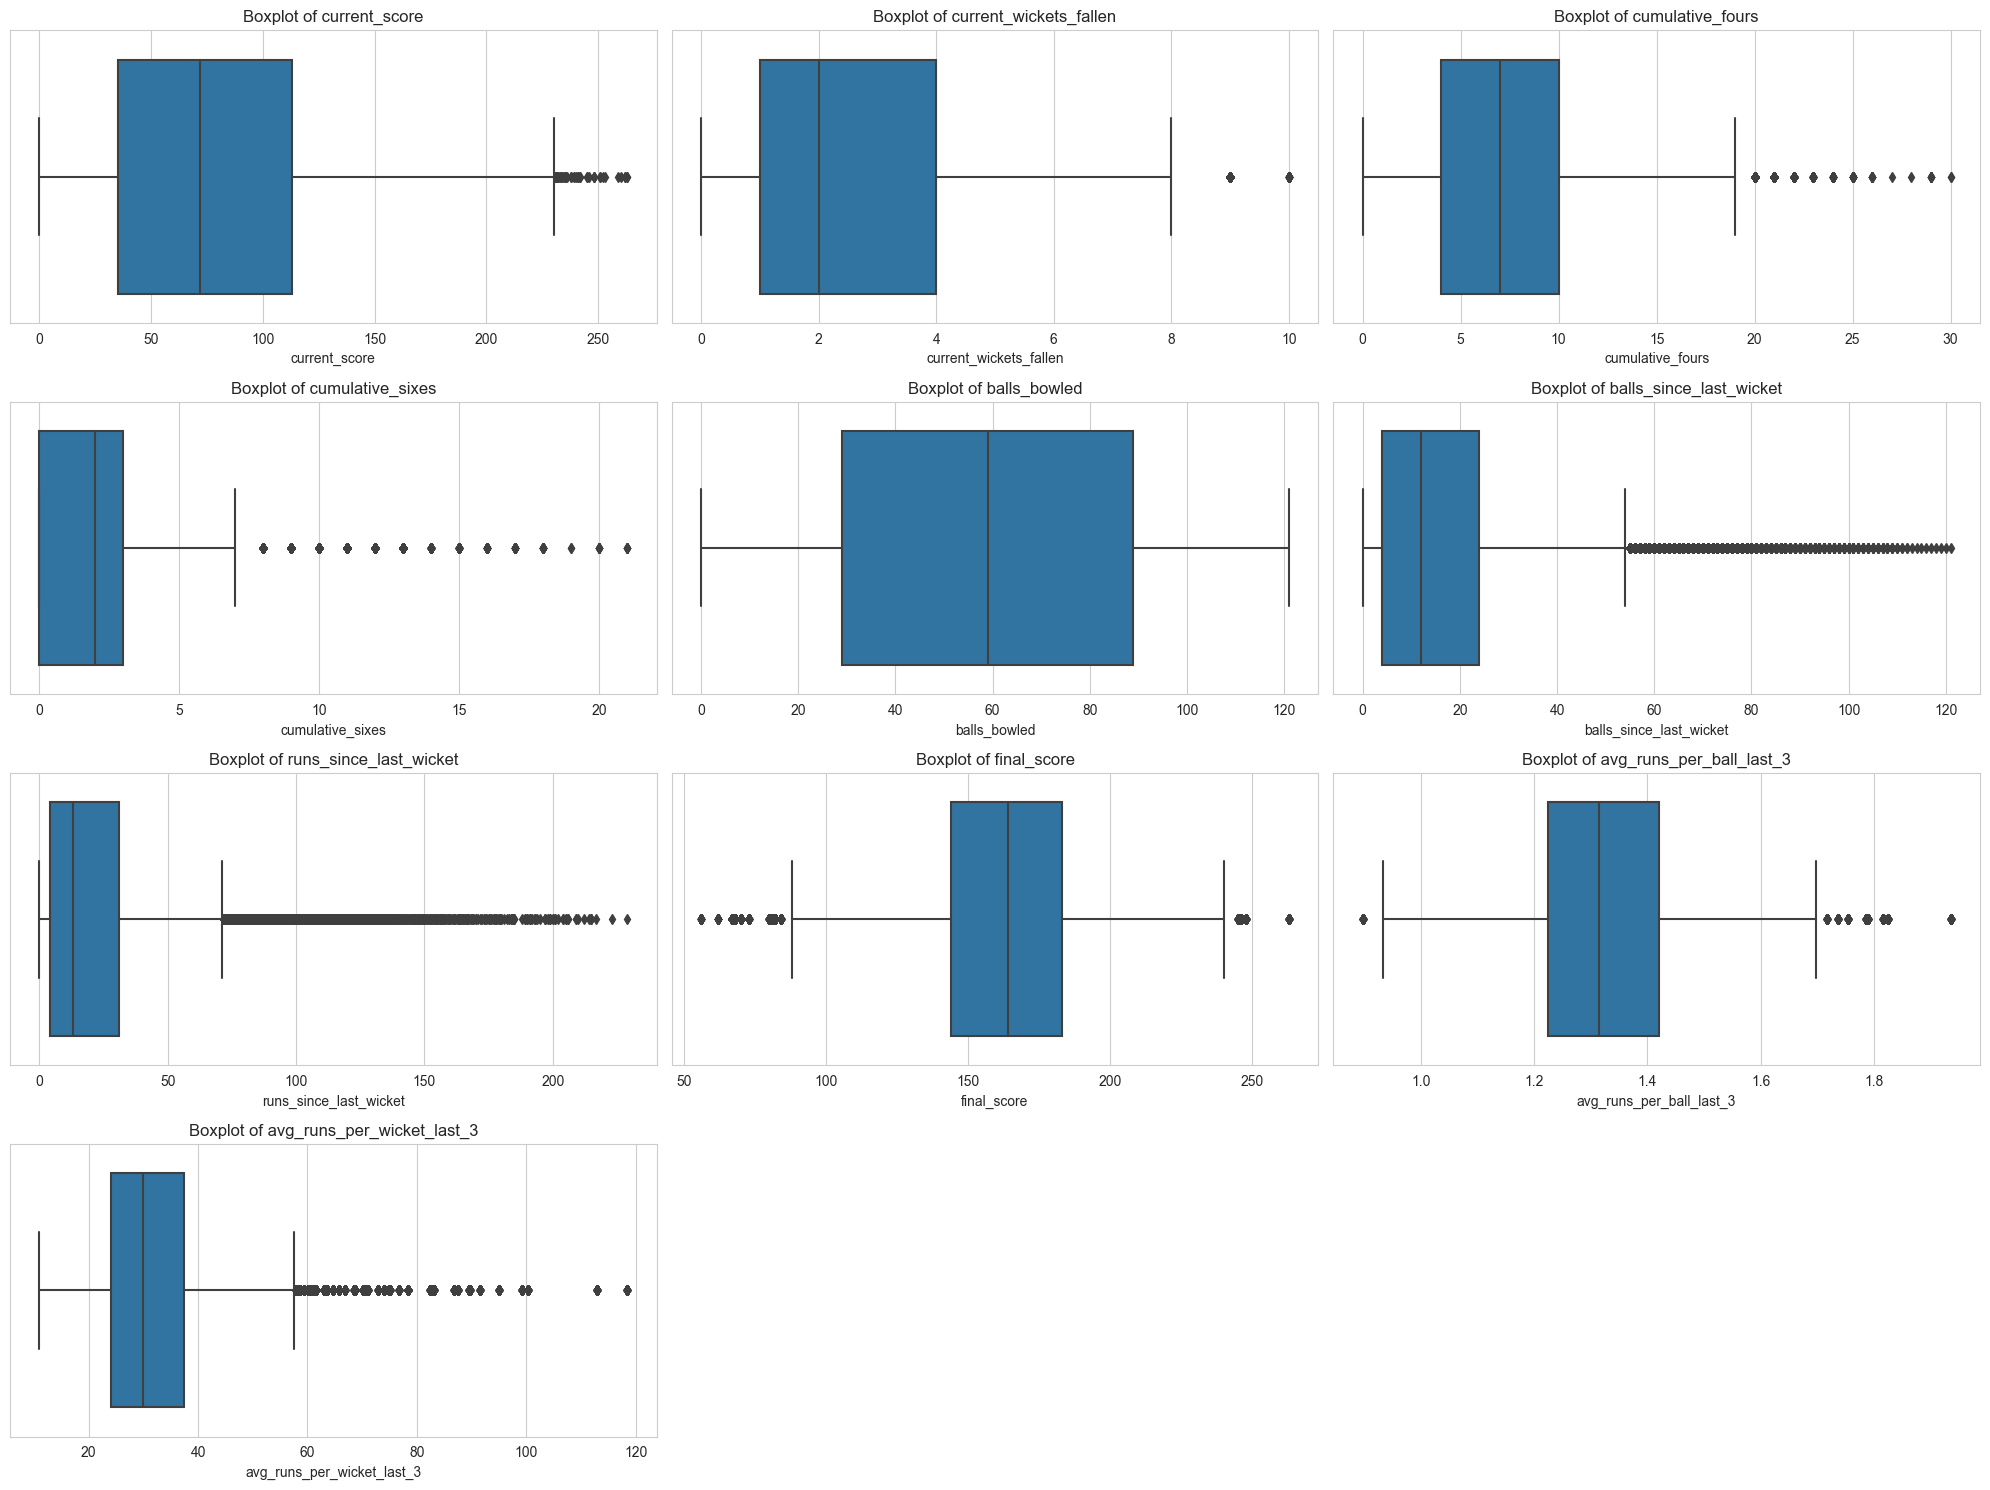

In [23]:
# Plot boxplots for numerical features to check for outliers
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=structured_df_with_form[feature])
    plt.title(f'Boxplot of {feature}')

# Show the plot
plt.tight_layout()
plt.show()


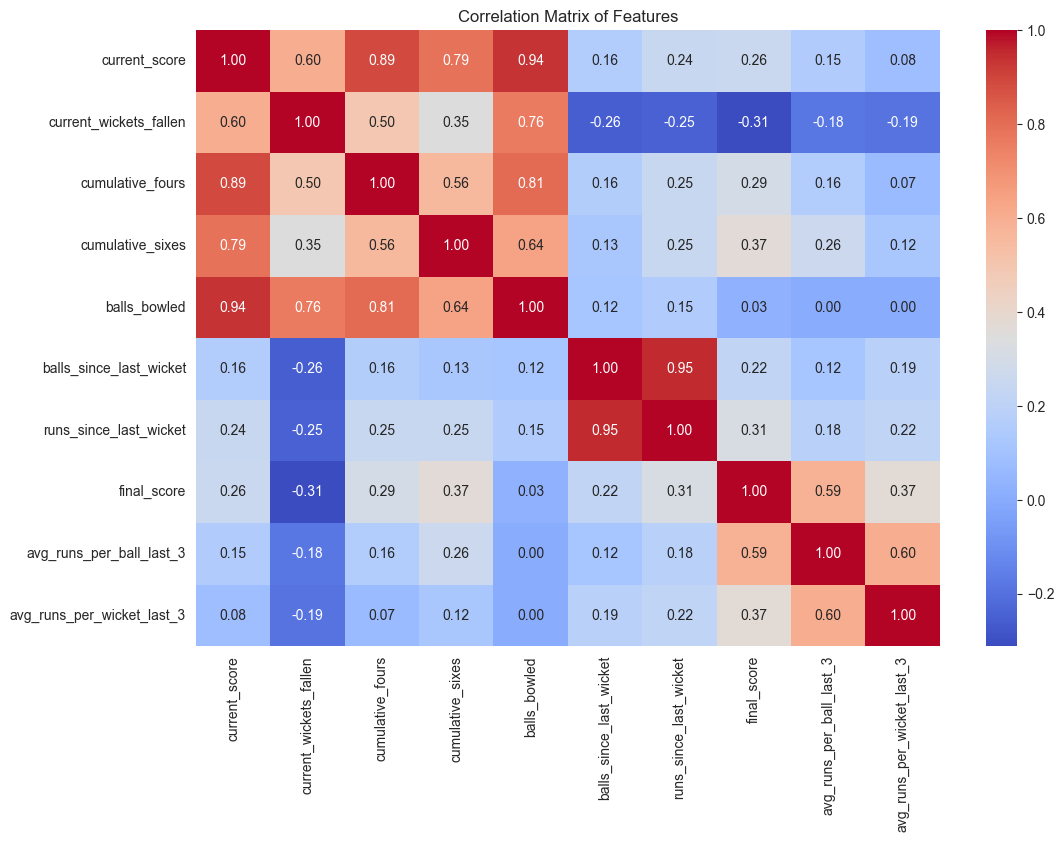

In [24]:
# Calculate the correlation matrix
correlation_matrix = structured_df_with_form[numerical_features].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


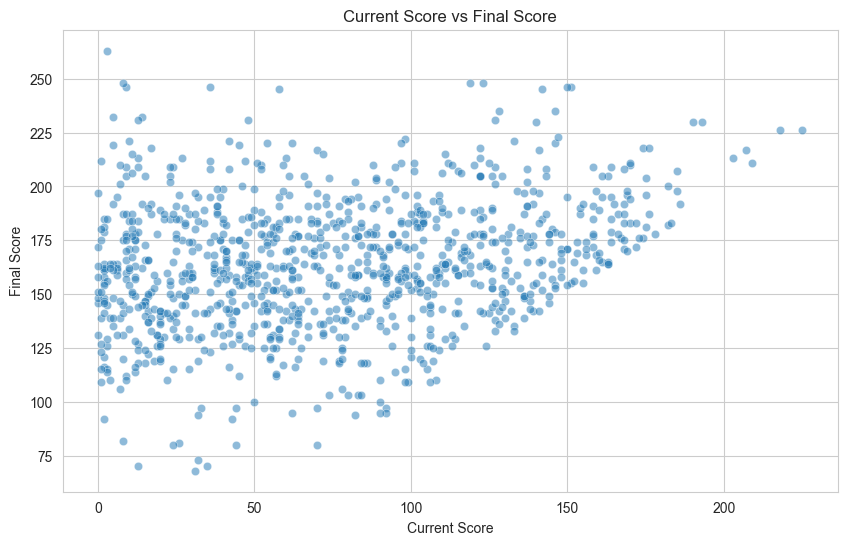

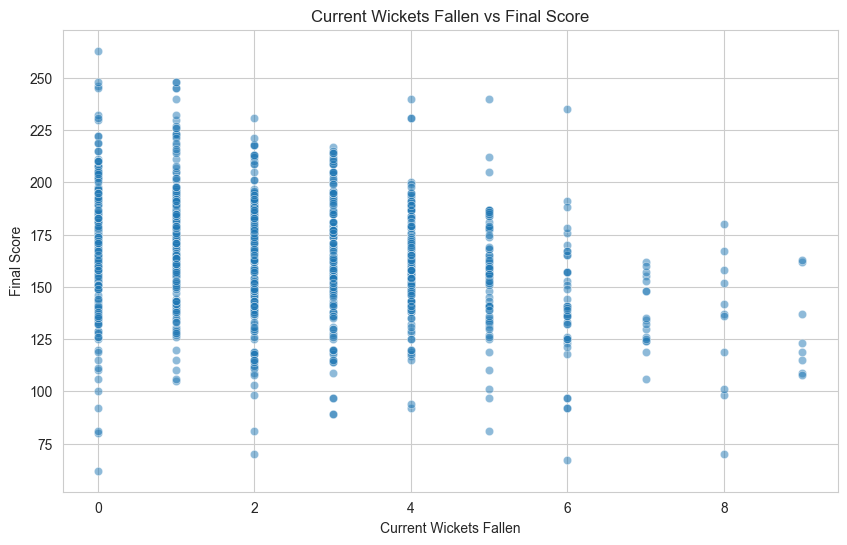

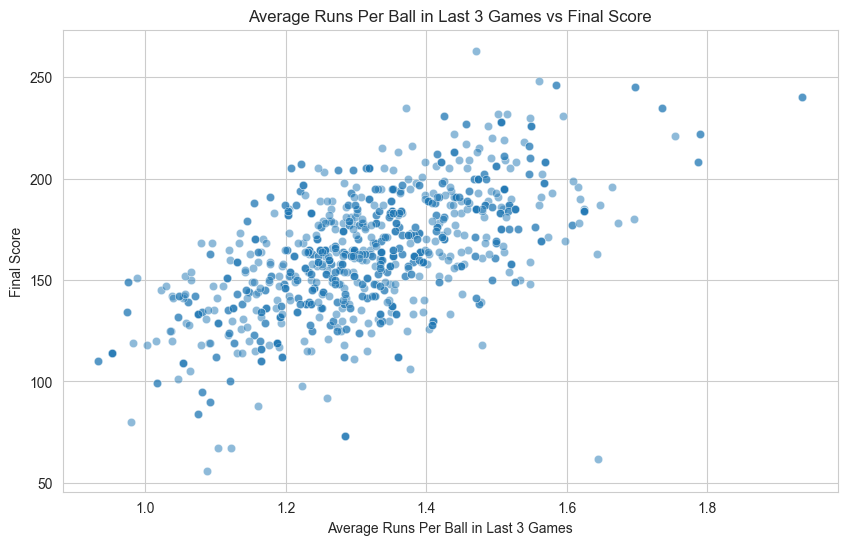

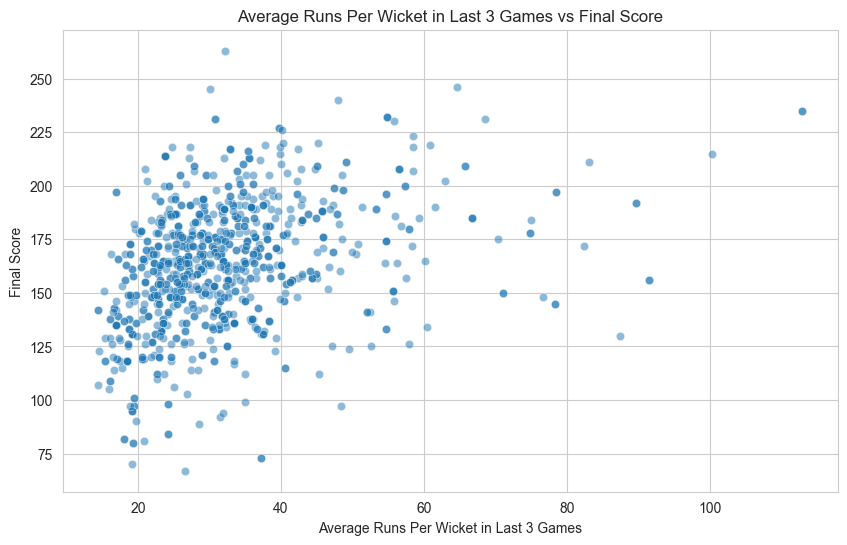

In [25]:
# Scatter plot of 'current_score' vs 'final_score'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='current_score', y='final_score', data=structured_df_with_form.sample(1000), alpha=0.5)
plt.title('Current Score vs Final Score')
plt.xlabel('Current Score')
plt.ylabel('Final Score')
plt.show()

# Scatter plot of 'current_wickets_fallen' vs 'final_score'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='current_wickets_fallen', y='final_score', data=structured_df_with_form.sample(1000), alpha=0.5)
plt.title('Current Wickets Fallen vs Final Score')
plt.xlabel('Current Wickets Fallen')
plt.ylabel('Final Score')
plt.show()

# Scatter plot of 'avg_runs_per_ball_last_3' vs 'final_score'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_runs_per_ball_last_3', y='final_score', data=structured_df_with_form.sample(1000), alpha=0.5)
plt.title('Average Runs Per Ball in Last 3 Games vs Final Score')
plt.xlabel('Average Runs Per Ball in Last 3 Games')
plt.ylabel('Final Score')
plt.show()

# Scatter plot of 'avg_runs_per_wicket_last_3' vs 'final_score'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_runs_per_wicket_last_3', y='final_score', data=structured_df_with_form.sample(1000), alpha=0.5)
plt.title('Average Runs Per Wicket in Last 3 Games vs Final Score')
plt.xlabel('Average Runs Per Wicket in Last 3 Games')
plt.ylabel('Final Score')
plt.show()


# Simple Models

In [26]:
venue_encoded_df = pd.get_dummies(structured_df_with_form['Venue'], prefix='Venue')
model_df = structured_df_with_form.join(venue_encoded_df)

In [27]:
model_df = model_df.drop(columns=['Venue'])

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    model_df.drop(columns=['ID', 'final_score']),
    model_df['final_score'],
    test_size=0.2
)
mean_final_score = y_train.mean()
mean_predictions = [mean_final_score] * len(y_test)
mae_mean_model = mean_absolute_error(y_test, mean_predictions)

mae_mean_model

23.14934898167111

In [30]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
mae_linear_model = mean_absolute_error(y_test, y_pred)
mae_linear_model, mae_mean_model # Returning both the MAE of the linear model and the baseline for comparison


(14.092100169606548, 23.14934898167111)

In [31]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
mae_random_forest = mean_absolute_error(y_test, y_pred_rf)

xgboost_model = xgb.XGBRegressor()
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgb)

mae_random_forest, mae_xgboost # Return the MAE of both models for comparison

(0.5172250502630791, 5.856734414073518)

In [32]:
# Initialize the models
random_forest_model = RandomForestRegressor()
xgboost_model = xgb.XGBRegressor()

# Perform cross-validation
rf_cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
xgb_cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Calculate the mean MAE for each model
rf_cv_mae = -rf_cv_scores.mean()
xgb_cv_mae = -xgb_cv_scores.mean()

print(f'Random Forest CV MAE: {rf_cv_mae}')
print(f'XGBoost CV MAE: {xgb_cv_mae}')

Random Forest CV MAE: 0.6941608630422993
XGBoost CV MAE: 5.947772196171677


In [33]:
random_forest_model.fit(X_train, y_train)
rf_feature_importances = random_forest_model.feature_importances_

xgboost_model.fit(X_train, y_train)
xgb_feature_importances = xgboost_model.feature_importances_

In [34]:
y_pred = random_forest_model.predict(X_test)
rf_test_mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Random Forest Test MAE: {rf_test_mae}")

Random Forest Test MAE: 0.5169790820036789


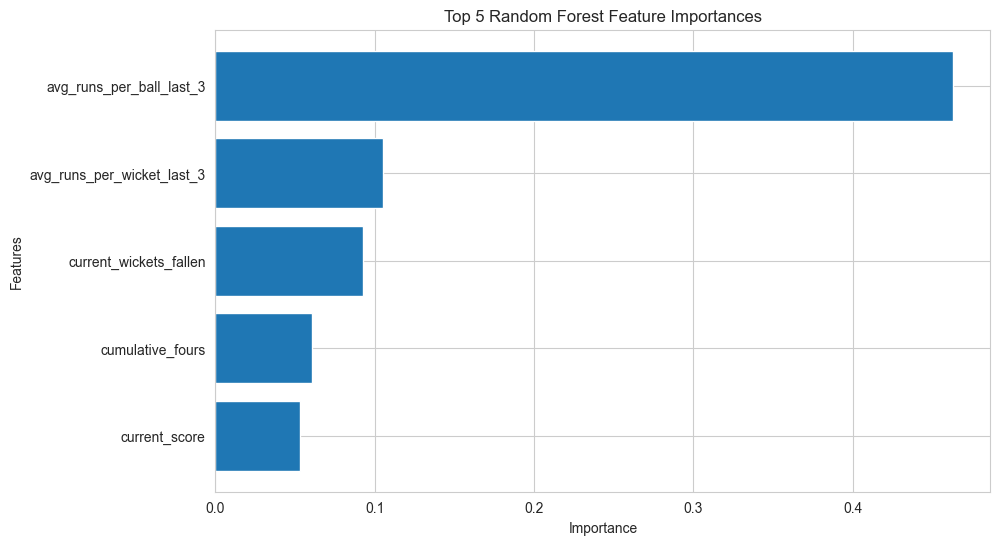

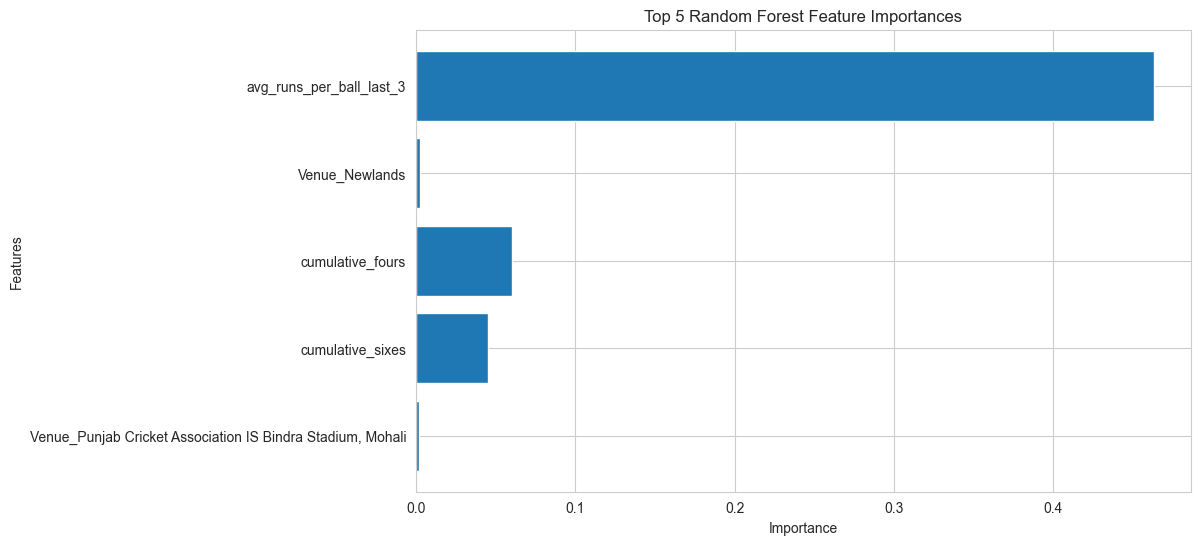

In [36]:
sorted_idx_rf = rf_feature_importances.argsort()[-5:]
top_features_rf = X_train.columns[sorted_idx_rf]

plt.figure(figsize=(10, 6))
plt.barh(top_features_rf, rf_feature_importances[sorted_idx_rf])
plt.title('Top 5 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

sorted_idx_xgb = xgb_feature_importances.argsort()[-5:]
top_features_xgb = X_train.columns[sorted_idx_xgb]

plt.figure(figsize=(10, 6))
plt.barh(top_features_xgb, rf_feature_importances[sorted_idx_xgb])
plt.title('Top 5 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()